In [1]:
from modules import SA_PAE_module
from data import CLEVR
import torch
import numpy as np
import matplotlib.pyplot as plt


def process_targets(target):
    """Unpacks the target into the CLEVR properties."""
    coords = target[:3]
    object_size = np.argmax(target[3:5])
    material = np.argmax(target[5:7])
    shape = np.argmax(target[7:10])
    color = np.argmax(target[10:18])
    real_obj = target[18]
    res = [coords, object_size, material, shape, color, real_obj]
    return res

# get the model and a data
train_data = CLEVR(split='train', max_objs=10, get_target=True)
val_data = CLEVR(split='val', max_objs=10, get_target=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
# sampled batch
sample = next(iter(train_loader))
model = SA_PAE_module(
        resolution=(128, 128),
        num_slots=11,
        num_iterations=3,
        hid_dim=64,
        batch_size=64,
        train_data=train_data,
        val_data=val_data,
        use_global_concepts=False,
    )

model.load_state_dict(torch.load('base_model.ckpt', map_location=torch.device('cpu'))['state_dict'], strict=False)

/Users/dkirilenko/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/dkirilenko/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <4EE76BD0-2599-3A0E-A5FC-2ECEE734BC2C> /Users/dkirilenko/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <709C1DF5-D253-3C66-87E2-C99FD3A259DF> /Users/dkirilenko/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


_IncompatibleKeys(missing_keys=['model.gmm.means', 'model.gmm.log_stds', 'model.gmm.weights'], unexpected_keys=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 128, 128])


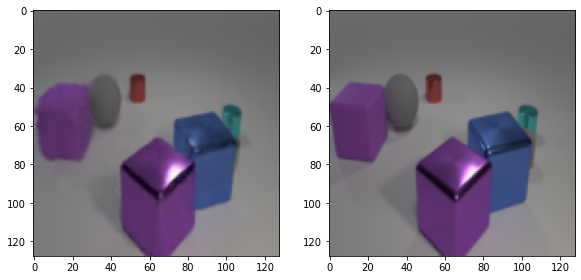

In [2]:
img = sample['image']
with torch.no_grad():
    recon_combined, recons, masks, slots, res, log_likelihood = model(img)
print(recon_combined.shape)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow((recon_combined[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)
plt.subplot(1, 3, 2)
plt.imshow((img[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)

In [3]:
# collect a set of slots and corresponding properties for 15 batches

slots = []
properties = []
i = 0
limit = 5
for batch in train_loader:
    print(i)
    img = batch['image']
    trgt = batch['target']
    with torch.no_grad():
        recon_combined, recons, masks, slots_batch, res, log_likelihood = model(img)
    for slot_set in slots_batch:
        for slot in slot_set:
            slots.append(slot)
    for target_set in res:
        for target in target_set:
            properties.append(process_targets(target))
    i += 1
    if i == limit:
        break

0
1
2
3
4


In [4]:
len(slots), slots[0].shape, len(properties), properties[0]
# transform the slots and properties into numpy arrays
for i in range(len(slots)):
    slots[i] = slots[i].cpu().numpy()
slots_np = np.array(slots)
for i in range(len(properties)):
    for j in range(len(properties[i])):
        properties[i][j] = properties[i][j].cpu().numpy()
properties = np.array(properties)

/var/folders/t0/sk690xhd5p563_7gjhjl97vh0000gn/T/ipykernel_45574/2269996934.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  properties = np.array(properties)


In [5]:
# visualize the slots with tsne

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
condition = properties[:, -1] > 0.9
slots_tsne = tsne.fit_transform(slots_np)
properties_tsne = properties
print(slots_tsne.shape)

/Users/dkirilenko/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/dkirilenko/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(3520, 2)


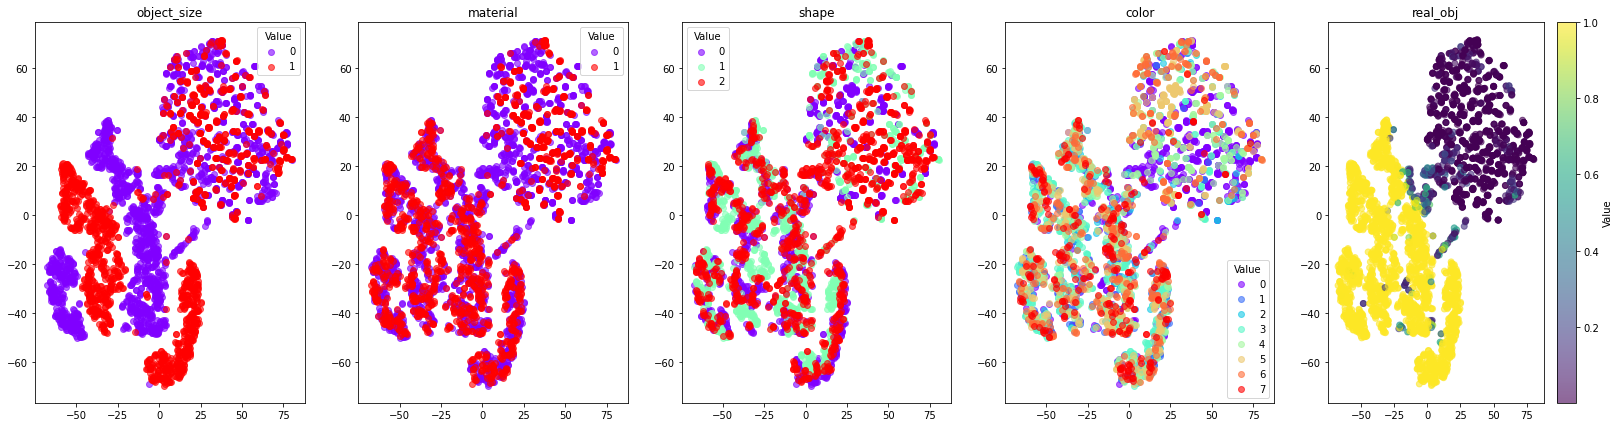

In [6]:
# the same plot but for all the remaining properties

fig, axs = plt.subplots(1, 5, figsize=(7*4, 7))
idx2name = {1: 'object_size', 2: 'material', 3: 'shape', 4: 'color', 5: 'real_obj'}
idx2num_of_possible_vals = {1: 2, 2: 2, 3: 3, 4: 8, 5: 2}

sizes = ['small', 'large']
materials = ['rubber', 'metal']
shapes = ['cube', 'sphere', 'cylinder']
colors = ['gray', 'blue', 'brown', 'yellow', 'red', 'green', 'purple', 'cyan']

axs = axs.flatten()
for i in range(5):
    if i != 4:  # Handle discrete values for the first four plots
        unique_vals = np.unique(properties_tsne[:, i + 1])
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_vals)))
        color_map = {int(val): colors[j] for j, val in enumerate(unique_vals)}

        for val in unique_vals:
            mask = properties_tsne[:, i + 1] == int(val)
            axs[i].scatter(slots_tsne[mask, 0], slots_tsne[mask, 1], 
                           color=color_map[int(val)], label=f'{int(val)}', alpha=0.6)

        axs[i].set_title(f'{idx2name[i + 1]}')
        axs[i].legend(title="Value")
    else:  # Handle continuous values for the last plot
        scatter = axs[i].scatter(slots_tsne[:, 0], slots_tsne[:, 1], 
                                 c=properties_tsne[:, i + 1], cmap='viridis', alpha=0.6)
        axs[i].set_title(f'{idx2name[i + 1]}')
        fig.colorbar(scatter, ax=axs[i], label='Value')

plt.show()    

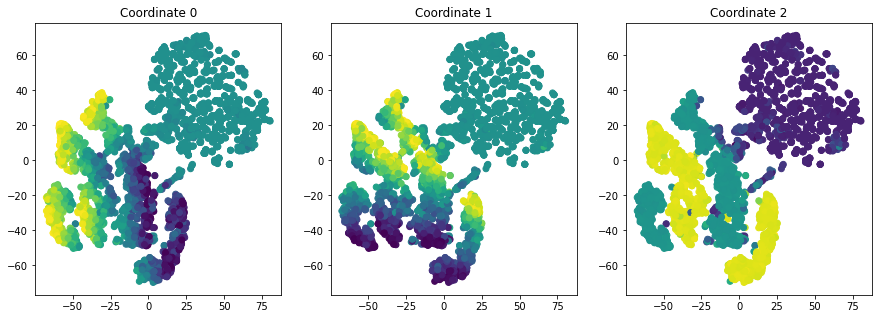

In [7]:
# position 0 in the properties is the coordinates (array of 3 continuous values), let's plot them as 3 separate plots together

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
for i in range(3):
    axs[i].scatter(slots_tsne[:, 0], slots_tsne[:, 1], c=np.stack(properties_tsne[:, 0])[:, i])
    axs[i].set_title(f'Coordinate {i}')

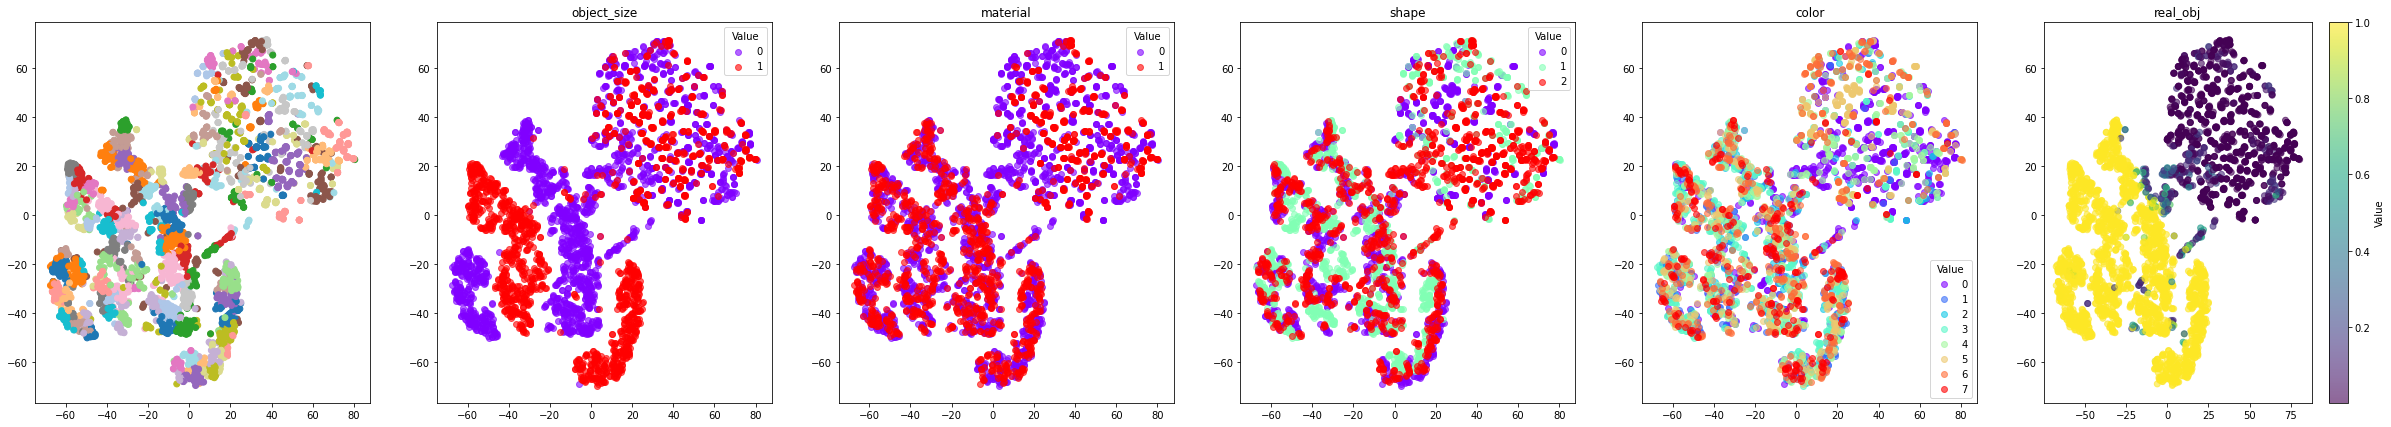

In [8]:
# plot the clustering results using tsne_slots next to the original properties plots
# convariances only diagonal
from sklearn.mixture import GaussianMixture
from sklearn import cluster
# kmeans = GaussianMixture(n_components=3, covariance_type='diag')
# kmeans = KMeans(n_clusters=4)
kmeans = GaussianMixture(n_components=100, covariance_type='diag')
cluster_labels = kmeans.fit_predict(slots_np)


fig, axs = plt.subplots(1, 6, figsize=(7*6, 7))
idx2name = {1: 'object_size', 2: 'material', 3: 'shape', 4: 'color', 5: 'real_obj'}
idx2num_of_possible_vals = {1: 2, 2: 2, 3: 3, 4: 8, 5: 2}

sizes = ['small', 'large']
materials = ['rubber', 'metal']
shapes = ['cube', 'sphere', 'cylinder']
colors = ['gray', 'blue', 'brown', 'yellow', 'red', 'green', 'purple', 'cyan']

axs = axs.flatten()

# plot the clustering results
axs[0].scatter(slots_tsne[:, 0], slots_tsne[:, 1], c=cluster_labels, cmap='tab20')

# plot the properties
for i in range(5):
    if i != 4:  # Handle discrete values for the first four plots
        unique_vals = np.unique(properties_tsne[:, i + 1])
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_vals)))
        color_map = {int(val): colors[j] for j, val in enumerate(unique_vals)}

        for val in unique_vals:
            mask = properties_tsne[:, i + 1] == int(val)
            axs[i + 1].scatter(slots_tsne[mask, 0], slots_tsne[mask, 1], 
                               color=color_map[int(val)], label=f'{int(val)}', alpha=0.6)

        axs[i + 1].set_title(f'{idx2name[i + 1]}')
        axs[i + 1].legend(title="Value")
    else:  # Handle continuous values for the last plot
        scatter = axs[i + 1].scatter(slots_tsne[:, 0], slots_tsne[:, 1], 
                                     c=properties_tsne[:, i + 1], cmap='viridis', alpha=0.6)
        axs[i + 1].set_title(f'{idx2name[i + 1]}')
        fig.colorbar(scatter, ax=axs[i + 1], label='Value')

In [9]:
# retrieve the distribution parameters 
# the parameters are the mean and the variance of the distribution and the weights of the clusters
mean = kmeans.means_
cov = kmeans.covariances_
weights = kmeans.weights_
mean.shape, cov.shape, weights.shape

((100, 64), (100, 64), (100,))

<BarContainer object of 100 artists>

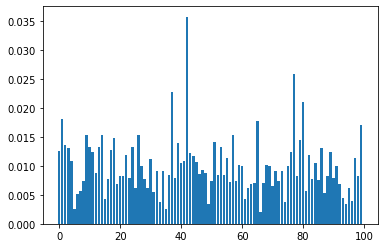

In [10]:
# plot the weights

plt.bar(np.arange(len(weights)), weights)

torch.Size([64, 3, 128, 128])


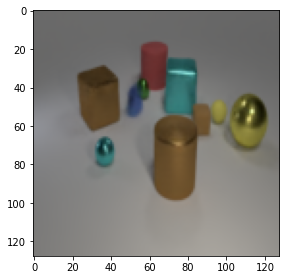

In [11]:
with torch.no_grad():
    recon_combined, recons, masks, slots, res, log_likelihood = model(img)
    recon_combined, recons, masks, slots_ = model.model.proc_slots(slots, img.shape[0])
print(recon_combined.shape)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow((recon_combined[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 128, 128])


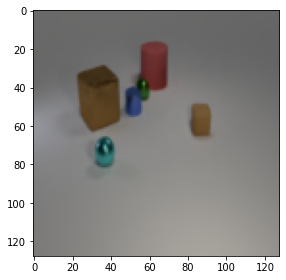

In [12]:
with torch.no_grad():
    recon_combined, recons, masks, slots, res, log_likelihood = model(img)
    # drop last 4 slots
    slots = slots[:, :-4]
    recon_combined, recons, masks, slots_ = model.model.proc_slots(slots, img.shape[0])
print(recon_combined.shape)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow((recon_combined[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)

torch.Size([64, 3, 128, 128])


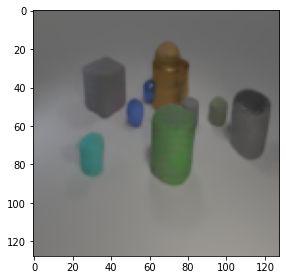

In [13]:
with torch.no_grad():
    recon_combined, recons, masks, slots, res, log_likelihood = model(img)
    # assign the slots to GMM (kmeans = GaussianMixture(n_components=100, covariance_type='diag')) and resample them, slots.shape = (batch_size, num_slots, hid_dim)
    # first we reshape slots, assign them to the clusters, sample from the assigned gaussiand using the reparametrization trick, and reshape them back
    slots = slots.reshape(-1, slots.shape[-1])
    cluster_labels = kmeans.predict(slots)
    means = kmeans.means_[cluster_labels]
    covs = kmeans.covariances_[cluster_labels]
    slots = means + np.sqrt(covs) * np.random.randn(*means.shape)
    slots = slots.reshape(img.shape[0], -1, slots.shape[-1])
    slots = torch.FloatTensor(slots)
    recon_combined, recons, masks, slots_ = model.model.proc_slots(slots, img.shape[0])
print(recon_combined.shape)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow((recon_combined[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)

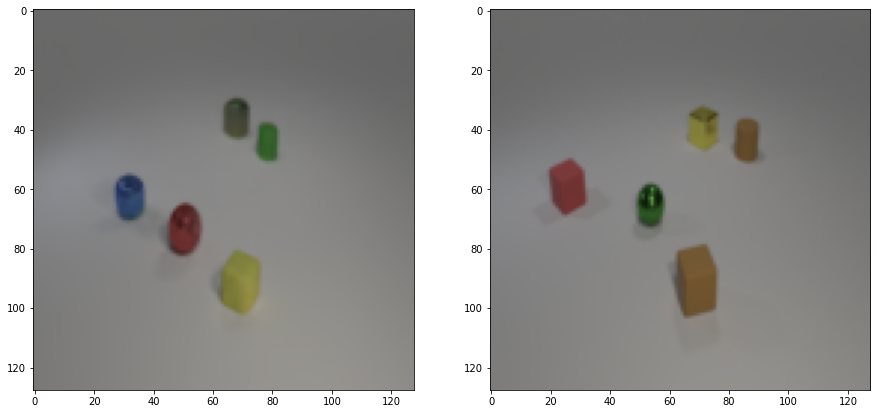

In [14]:
# plot original, and resampled images
idx = np.random.randint(0, img.shape[0])
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow((recon_combined[idx].permute(1, 2, 0).cpu().numpy() + 1) / 2)
plt.subplot(1, 2, 2)
plt.imshow((img[idx].permute(1, 2, 0).cpu().numpy() + 1) / 2)


In [15]:
kmeans = GaussianMixture(n_components=100, covariance_type='diag')
cluster_labels = kmeans.fit_predict(slots_np)

In [16]:
# the same but lover covariance
with torch.no_grad():
    recon_combined, recons, masks, slots, res, log_likelihood = model(img)
    # assign the slots to GMM (kmeans = GaussianMixture(n_components=100, covariance_type='diag')) and resample them, slots.shape = (batch_size, num_slots, hid_dim)
    # first we reshape slots, assign them to the clusters, sample from the assigned gaussiand using the reparametrization trick, and reshape them back
    slots = slots.reshape(-1, slots.shape[-1])
    cluster_labels = kmeans.predict(slots)
    means = kmeans.means_[cluster_labels]
    covs = kmeans.covariances_[cluster_labels]
    # slots = means + np.sqrt(covs) * np.random.randn(*means.shape)
    slots = means + np.sqrt(covs) * np.random.randn(*means.shape) * 0.5
    slots = slots.reshape(img.shape[0], -1, slots.shape[-1])
    slots = torch.FloatTensor(slots)
    recon_combined_low, recons, masks, slots_ = model.model.proc_slots(slots, img.shape[0])
print(recon_combined_low.shape)

# plt.figure(figsize=(15, 15))
# plt.subplot(1, 3, 1)
# plt.imshow((recon_combined_low[0].permute(1, 2, 0).cpu().numpy() + 1) / 2)

torch.Size([64, 3, 128, 128])


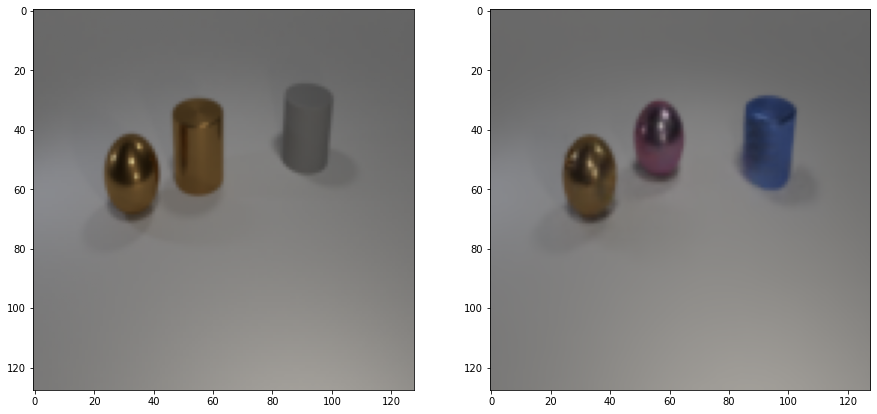

In [30]:
# plot original, and resampled images
idx = np.random.randint(0, img.shape[0])
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow((img[idx].permute(1, 2, 0).cpu().numpy() + 1) / 2)
plt.subplot(1, 2, 2)
plt.imshow((recon_combined_low[idx].permute(1, 2, 0).cpu().numpy() + 1) / 2)

In [515]:
# implementation of the pytorch GMM module
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F


class GMM(nn.Module):
    def __init__(self, num_components, input_dim, log_std=True, grad_w=True, detach=True, log_mean=False):
        super(GMM, self).__init__()
        self.num_components = num_components
        self.input_dim = input_dim
        self.means = nn.Parameter(torch.randn(num_components, input_dim)*5) 
        self.stds = nn.Parameter(torch.randn(num_components, input_dim))
        if grad_w:
            self.weights = nn.Parameter(torch.ones(num_components))
        else:
            self.weights = nn.Parameter(torch.randn(num_components), requires_grad=True)
        self.use_log_std = log_std
        self.detach = detach
        self.log_mean = log_mean

    def forward(self, input):
        """
        Args:
            input: (batch_size, input_dim)
            
        Returns:
            resampled_x: (batch_size, input_dim)
            idxs: (batch_size)
            mean_likelihood: 
        """
        idxs, log_likelihood = self.assign(input, self.means, self.stds, self.weights)
        resampled_x = self.resample(idxs, self.means, self.stds)
        return resampled_x, idxs, log_likelihood
    
    def assign(self, input, means, stds, weights):
        prior_mix = D.Categorical(logits=weights)
        # prior_mix = D.Categorical(probs=weights)
        components = D.Independent(D.Normal(means, stds.exp()), 1)
        gmm = D.MixtureSameFamily(prior_mix, components)    

        # probability of each input belonging to each cluster
        log_p_x_z = gmm.component_distribution.log_prob(input.unsqueeze(1))
        # prior probability of each cluster
        log_p_z = torch.log_softmax(
            gmm.mixture_distribution.logits, dim=-1
        )

        # posterior probability of each cluster given the input
        p_z_x = F.softmax(log_p_x_z + log_p_z
                          , dim=-1)
        # p_z_x.shape = (batch_size, num_components)
        # print('p_z_x mean', p_z_x.mean(0))
        # hard assignment
        idxs = torch.argmax(p_z_x, dim=-1)
        Q = (p_z_x.detach() * (log_p_x_z + log_p_z)).mean()
        # Q = (log_p_x_z + log_p_z).mean()

        return idxs, Q
    
    def resample(self, idxs, means, stds):
        resampled_x = means[idxs] + stds[idxs] * torch.randn_like(means[idxs])
        return resampled_x
    
    def classical_step(self, input):
        stds = torch.clamp(self.stds.exp(), max=1e6)
        components = D.Independent(D.Normal(self.means, stds), 1)
        
        prior_mix = D.Categorical(logits=self.weights)
        gmm = D.MixtureSameFamily(prior_mix, components)
        
        log_p_x_z = gmm.component_distribution.log_prob(input.unsqueeze(1))
        log_p_z = torch.log_softmax(gmm.mixture_distribution.logits, dim=-1)
        
        p_z_x = F.softmax(log_p_x_z + log_p_z, dim=-1)
        
        idxs = torch.argmax(p_z_x, dim=-1)
        new_priors = p_z_x.mean(0)
        
        # Avoid division by zero
        denominator = p_z_x.sum(0).unsqueeze(-1) + 1e-9
        new_means = (p_z_x.unsqueeze(-1) * input.unsqueeze(1)).sum(0) / denominator
        
        # Compute new stds safely
        variance = (p_z_x.unsqueeze(-1) * (input.unsqueeze(1) - new_means.unsqueeze(0)).pow(2)).sum(0) / denominator
        new_stds = torch.sqrt(torch.clamp(variance, min=1e-9))
        
        Q = (p_z_x.detach() * (log_p_x_z + log_p_z)).mean()
        
        # Update parameters safely
        self.means.data = new_means
        self.stds.data = torch.log(torch.clamp(new_stds, min=1e-9))
        self.weights.data = torch.log(torch.clamp(new_priors, min=1e-9))
        return idxs, Q


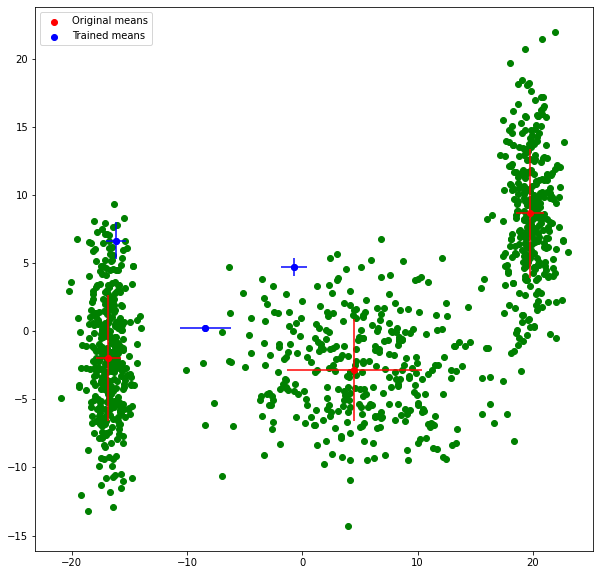

In [523]:
from tqdm import tqdm
import matplotlib.pyplot as plt

num_components = 3
iter_n = 20000

t_gmm = GMM(num_components=num_components, input_dim=2, log_std=True)
t_gmm_nolog = GMM(num_components=num_components, input_dim=2, log_std=False)
t_gmm_nograd = GMM(num_components=num_components, input_dim=2, log_std=True, grad_w=False)
t_gmm_nodetach = GMM(num_components=num_components, input_dim=2, log_std=True, detach=False)
t_gmm_logmean = GMM(num_components=num_components, input_dim=2, log_std=True, log_mean=True)
t_gmm_classic = GMM(num_components=num_components, input_dim=2, log_std=True)
#init with weights from t_gmm
# sk_gmm = GaussianMixture(n_components=num_components, covariance_type='diag', weights_init=(t_gmm.weights.exp() / t_gmm.weights.exp().sum()).detach().numpy(), means_init=t_gmm.means.detach().numpy(), precisions_init=1/np.sqrt(t_gmm.stds.exp().detach().numpy()), max_iter=iter_n)
sk_gmm = GaussianMixture(
    n_components=num_components,
    covariance_type='diag',
    init_params='kmeans',
    max_iter=iter_n
)

n_points = 1024
# initialize n random gaussians 
means = torch.randn(1, num_components, 2)*12
stds = torch.randn(1, num_components, 2).abs() *5

# choose randomly one of them and sample from it, repeat 128 times
x = means + stds * torch.randn(n_points, num_components, 2)
idx = torch.randint(0, num_components, (n_points,))
x = x[torch.arange(n_points), idx]

# sk_gmm.fit(x)
# t_gmm.means.data = torch.FloatTensor(sk_gmm.means_.copy())
# t_gmm.stds.data = torch.FloatTensor(1/np.sqrt(sk_gmm.precisions_).copy())

#plot the initial gaussians alongside with the gt ones and the sampled point
plt.figure(figsize=(10, 10))
plt.scatter(means[:, :, 0], means[:, :, 1], color='r', label='Original means')
plt.scatter(t_gmm.means[:, 0].detach().numpy(), t_gmm.means[:, 1].detach().numpy(), color='b', label='Trained means')
for i in range(num_components):
    plt.errorbar(means[0, i, 0], means[0, i, 1], xerr=stds[0, i, 0], yerr=stds[0, i, 1], fmt='o', color='r')
    plt.errorbar(t_gmm.means[i, 0].detach().numpy(), t_gmm.means[i, 1].detach().numpy(), xerr=t_gmm.stds[i, 0].detach().numpy(), yerr=t_gmm.stds[i, 1].detach().numpy(), fmt='o', color='b')
    # sklearn gmm
    # plt.errorbar(sk_gmm.means_init[i, 0], sk_gmm.means_init[i, 1], xerr=1/(sk_gmm.precisions_init[i, 0]), yerr=1/(sk_gmm.precisions_init[i, 1]), fmt='o', color='orange')
plt.legend()
plt.scatter(x[:, 0], x[:, 1], color='g', label='Sampled points')
plt.show()

#plot sampled points from the original gaussians

plt.show()
means = means.squeeze().detach().numpy()
stds = stds.squeeze().detach().numpy()

100%|██████████| 20000/20000 [00:26<00:00, 744.16it/s]


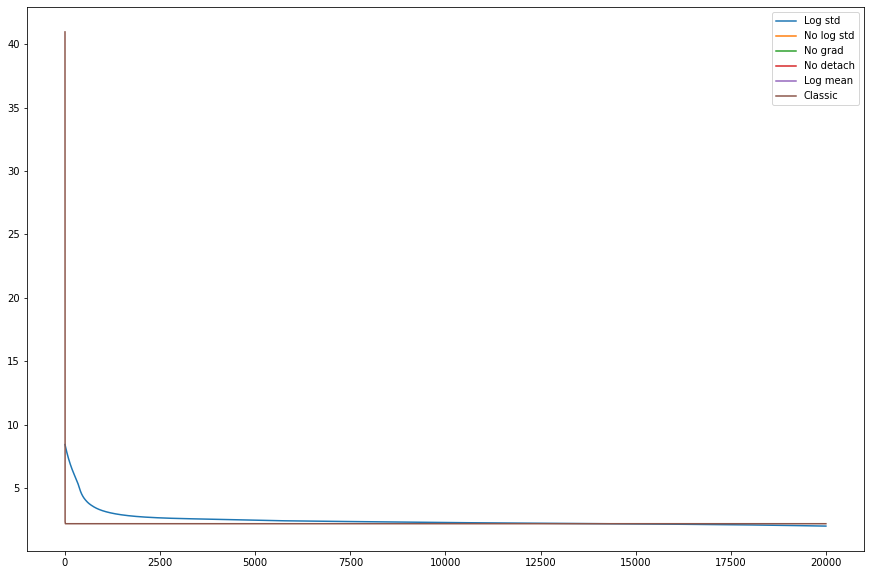

-6.0067403549175555


In [524]:
# train the GMM by optimizing the log likelihood, plot loss in the end, use tqdm
optimizer = torch.optim.Adam(t_gmm.parameters(), lr=0.001)
losses_log = []
losses_nolog = []
losses_nograd = []
losses_nodetach = []
losses_logmean = []
losses_classic = []
for i in tqdm(range(iter_n)):
    optimizer.zero_grad()
    resampled_x, idxs, log_likelihood = t_gmm(x)
    # resampled_x_nolog, idxs_nolog, log_likelihood_nolog = t_gmm_nolog(x)
    # resampled_x_nograd, idxs_nograd, log_likelihood_nograd = t_gmm_nograd(x)
    # resampled_x_nodetach, idxs_nodetach, log_likelihood_nodetach = t_gmm_nodetach(x)
    # resampled_x_logmean, idxs_logmean, log_likelihood_logmean = t_gmm_logmean(x)
    loss = -log_likelihood #- log_likelihood_nodetach #- log_likelihood_logmean #- log_likelihood_nolog - log_likelihood_nograd - log_likelihood_nodetach
    loss.backward()
    optimizer.step()
    losses_log.append(-log_likelihood.item())
    _, clas_loss = t_gmm_classic.classical_step(x)
    losses_classic.append(-clas_loss.item())
    # losses_nolog.append(-log_likelihood_nolog.item())
    # losses_nograd.append(-log_likelihood_nograd.item())
    # losses_nodetach.append(-log_likelihood_nodetach.item())
    # losses_logmean.append(-log_likelihood_logmean.item())


# plot the loss and gmm parameters (original and trained)
plt.figure(figsize=(15, 10))
plt.plot(losses_log, label='Log std')
plt.plot(losses_nolog, label='No log std')
plt.plot(losses_nograd, label='No grad')
plt.plot(losses_nodetach, label='No detach')
plt.plot(losses_logmean, label='Log mean')
plt.plot(losses_classic, label='Classic')
plt.legend()
plt.show()

# sklearn GMM
sk_gmm.fit(x)
print(sk_gmm.score(x))


means_trained = t_gmm.means.detach().numpy()
stds_trained = t_gmm.stds.exp().detach().numpy()
means_trained_nolog = t_gmm_nolog.means.detach().numpy()
stds_trained_nolog = t_gmm_nolog.stds.detach().numpy()
means_trained_nograd = t_gmm_nograd.means.detach().numpy()
stds_trained_nograd = t_gmm_nograd.stds.exp().detach().numpy()
means_trained_nodetach = t_gmm_nodetach.means.detach().numpy()
stds_trained_nodetach = t_gmm_nodetach.stds.exp().detach().numpy()
means_trained_classic = t_gmm_classic.means.detach().numpy()
stds_trained_classic = t_gmm_classic.stds.exp().detach().numpy()

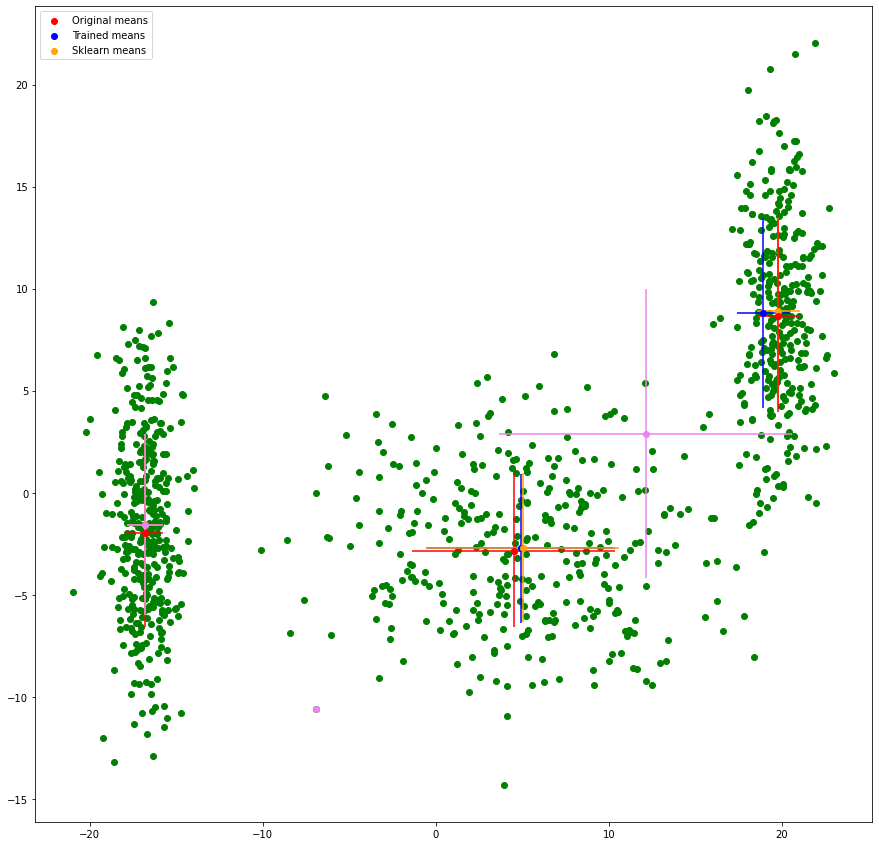

In [525]:
# plot the original gaussians and the trained ones (means as points and stds as ellipses)
plt.figure(figsize=(15, 15))
plt.scatter(means[:, 0], means[:, 1], color='r', label='Original means')
plt.scatter(means_trained[:, 0], means_trained[:, 1], color='b', label='Trained means')
plt.scatter(sk_gmm.means_[:, 0], sk_gmm.means_[:, 1], color='orange', label='Sklearn means')
for i in range(num_components):
    plt.errorbar(means[i, 0], means[i, 1], xerr=stds[i, 0], yerr=stds[i, 1], fmt='o', color='r')
    plt.errorbar(means_trained[i, 0], means_trained[i, 1], xerr=(stds_trained[i, 0]), yerr=(stds_trained[i, 1]), fmt='o', color='blue')
    # sklearn gmm
    plt.errorbar(sk_gmm.means_[i, 0], sk_gmm.means_[i, 1], xerr=np.sqrt(sk_gmm.covariances_[i, 0]), yerr=np.sqrt(sk_gmm.covariances_[i, 1]), fmt='o', color='orange')
    plt.errorbar(means_trained_classic[i, 0], means_trained_classic[i, 1], xerr=(stds_trained_classic[i, 0]), yerr=(stds_trained_classic[i, 1]), fmt='o', color='violet')
    # plt.errorbar(means_trained_nolog[i, 0], means_trained_nolog[i, 1], xerr=stds_trained_nolog[i, 0], yerr=stds_trained_nolog[i, 1], fmt='o', color='purple')
    # plt.errorbar(means_trained_nograd[i, 0], means_trained_nograd[i, 1], xerr=stds_trained_nograd[i, 0], yerr=stds_trained_nograd[i, 1], fmt='o', color='black')
    # plt.errorbar(means_trained_nodetach[i, 0], means_trained_nodetach[i, 1], xerr=stds_trained_nodetach[i, 0], yerr=stds_trained_nodetach[i, 1], fmt='o', color='blue')
plt.legend()
plt.scatter(x[:, 0], x[:, 1], color='g', label='Sampled points')
plt.show()

In [519]:
# original params, trained params, sklearn params
prior_mix = D.Categorical(logits=t_gmm.weights)
prior_mix_sk = D.Categorical(logits=torch.tensor(sk_gmm.weights_))
prior_mix.probs, prior_mix_sk.probs

(tensor([6.9316e-01, 3.0684e-01, 5.1390e-06], grad_fn=<SoftmaxBackward0>),
 tensor([0.3329, 0.3423, 0.3248], dtype=torch.float64))

In [498]:
means, stds, means_trained, stds_trained, sk_gmm.means_, np.sqrt(sk_gmm.covariances_)

(array([[-10.751021, -18.923933],
        [-24.901047,   4.771982],
        [ -1.187711,  16.548586]], dtype=float32),
 array([[4.4821877, 1.0653098],
        [5.8576083, 3.1340833],
        [1.6781474, 2.2826104]], dtype=float32),
 array([[-1.954073  ,  0.62732273],
        [-7.760292  ,  5.9284644 ],
        [-7.234482  , 11.344633  ]], dtype=float32),
 array([[2.228988  , 2.0461006 ],
        [0.98265314, 0.86786723],
        [0.8888567 , 0.5475238 ]], dtype=float32),
 array([[-10.6625393 , -18.91482396],
        [ -1.2101553 ,  16.67154916],
        [-25.52170654,   4.50740438]]),
 array([[4.47320213, 1.09776312],
        [1.70897062, 2.31848138],
        [5.88055247, 3.13582384]]))

In [24]:
t_gmm.weights

Parameter containing:
tensor([1.0427, 0.9119, 1.0004], requires_grad=True)